In [1]:
import pystan
import numpy as np 
import pandas as pd

In [2]:
player = {'Player 1': -2, 'Player 2': -1, 'Player 3': 0, 'Player 4': 1, 'Player 5': 2}
pDF = pd.DataFrame(columns = ['player', 'p_avg'])
pDF['player'] = player.keys()
pDF['p_avg'] = player.values()
hole = {'Hole 1': {'h_avg': 3, 'h_dsr': 0.2}, 'Hole 2':{'h_avg': 4, 'h_dsr': 0.3}, 'Hole 3': {'h_avg': 5, 'h_dsr': 0.4}}
#hole = {'Hole 1': {'h_avg': 3, 'h_dsr': -0.2}, 'Hole 2':{'h_avg': 4, 'h_dsr': 0.0}, 'Hole 3': {'h_avg': 5, 'h_dsr': 0.1}}
hDF = pd.DataFrame(hole).transpose()

sets = 5
combinations = 15 # out of 3*5=15 total
np.random.seed(888)
error = np.random.normal(0,.0001, size = combinations*sets)
#print(error)

df = pd.DataFrame(columns = ['player', 'hole', 'p_avg', 'h_avg', 'h_dsr'])
i=0
while i in range(sets):
    for p, a in player.items():
        for h, d in hole.items():
            row = {'player': p, 'hole': h, 'p_avg': a, 'h_avg': d['h_avg'], 'h_dsr': d['h_dsr']}
            df = df.append(row, ignore_index=True)
    i = i + 1
#min_dsr = np.min(df['h_dsr'])
df['err'] = error
df['score'] = df['h_avg']-(df['p_avg']*df['h_dsr']) + df['err']
df[['p_avg', 'h_avg','h_dsr','err','score']] = df[['p_avg', 'h_avg','h_dsr','err','score']].apply(pd.to_numeric)
df.to_csv('simple_data.csv')

In [53]:
plyr_data = df['player'].map(lambda x: int(x.lstrip('Player ')))
hole_data = df['hole'].map(lambda x: int(x.lstrip('Hole ')))

In [54]:
# exact model -sigvector from Stephen Jesse paper
# this one working 

unstandard_code = """
data {
  int<lower=0> N;
  int<lower=0> nplayers;
  int<lower=0> nholes;
  vector<lower=0>[N] y;
  int<lower=1, upper=nplayers> playerid[N];
  int<lower=1, upper=nholes> holeid[N];
}
parameters {
    vector[nplayers] x;
    vector<lower = 0>[nholes] alpha;
    vector<lower=0, upper=1> [nholes] beta;
    real<lower=0> sigma;
    
}
transformed parameters {
    vector[N] y_hat;
    
    real<lower=-0.2, upper = 0.2> xmean;
    real xsd;
    
    real amean;
    real asd;
    
    real<lower=0, upper = 1> bmean;
    real bsd;
    
    
    xmean = mean(x);
    xsd = sd(x);
    
    amean = mean(alpha);
    asd = sd(alpha);
    
    bmean = mean(beta);
    bsd = sd(beta);
    
    for (i in 1:N){
        y_hat[i] = alpha[holeid[i]] - beta[holeid[i]]*x[playerid[i]];
        
    }
}

model {
    sigma ~ normal(0,.8);
    x ~ normal(0, 1);
    alpha ~ normal(3, 1);
    beta ~ normal(0, 1);
    y ~ normal(y_hat, sigma);
}
"""

In [55]:
fake_data = {      'N': len(df['score']),
                    'nplayers': len(df['player'].unique()) ,
                    'nholes': len(df['hole'].unique()),
                    'y': df['score'],
                    'playerid': plyr_data,
                    'holeid': hole_data
            }

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c7e4ea48f1fd73486d267dac478778e8 NOW.


Inference for Stan model: anon_model_c7e4ea48f1fd73486d267dac478778e8.
2 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x[1]       -1.62    0.23   0.27  -2.09  -1.87  -1.65  -1.37   -1.2      1   2.69
x[2]        -0.8    0.18    0.2  -1.12  -0.97  -0.82   -0.6  -0.52      1   3.25
x[3]        0.03    0.13   0.13  -0.18   -0.1   0.04   0.16   0.19      1   3.21
x[4]        0.86    0.08   0.11   0.58   0.81   0.86   0.94   1.09      2   1.64
x[5]        1.69    0.06   0.15   1.34    1.6   1.71   1.77   2.02      8   1.31
alpha[1]    3.01    0.03   0.03   2.95   2.98   3.01   3.04   3.05      1   3.22
alpha[2]    4.01    0.05   0.05   3.93   3.97   4.01   4.06   4.08      1   3.22
alpha[3]    5.02    0.06   0.07   4.91   4.96   5.02   5.08    5.1      1   3.22
beta[1]     0.24    0.01   0.03    0.2   0.22   0.24   0.26    0.3      3   1.73
b

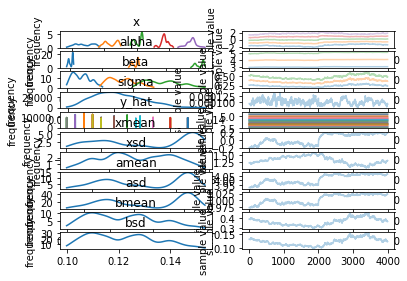

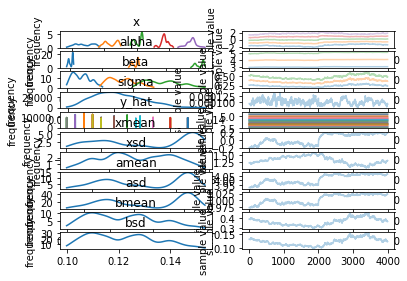

In [56]:
# THIS ONE running stephen's model on fake data

fit = pystan.stan(model_code=unstandard_code, data=fake_data, iter = 4000, chains=2)

la = fit.extract(permuted=True)  # return a dictionary of arrays

## return an array of three dimensions: iterations, chains, parameters
a = fit.extract(permuted=False)
print(fit)
fit.plot()

In [57]:
dataframe = fit.to_dataframe(inc_warmup=False, diagnostics=False)
#print(dataframe.head(100))
i=1
k=1
x = []
alpha = []
beta = []
while i < len(player)+1:
    
    x.append(np.average(dataframe[f'x[{i}]']))
    i = i+1
    
while k < len(hole)+1:
    beta.append(np.average(dataframe[f'beta[{k}]']))
    alpha.append(np.average(dataframe[f'alpha[{k}]']))
    k = k+1
print(x)
print(alpha)
print(beta)

[-1.6244108091990466, -0.7958169826799215, 0.032766478378402734, 0.8613872657609379, 1.690103676061224]
[3.0099471167746747, 4.014872301372696, 5.019831345846613]
[0.24408510730773328, 0.3661653143022436, 0.48824253629501635]


In [58]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

pRMSE = sqrt(mean_squared_error(pDF['p_avg'], x))			# taking RMSE from predicted values compared to our "true values" set out in first file
print(f"Root mean squared error for the player average is {pRMSE}")

hRMSE = sqrt(mean_squared_error(hDF['h_avg'], alpha))			# taking RMSE from predicted values compared to our "true values" set out in first file
print(f"Root mean squared error for the hole average is {hRMSE}")

dRMSE = sqrt(mean_squared_error(hDF['h_dsr'], beta))			# taking RMSE from predicted values compared to our "true values" set out in first file
print(f"Root mean squared error for the discrimination average is {dRMSE}")

Root mean squared error for the player average is 0.24457342807335566
Root mean squared error for the hole average is 0.015420903111656314
Root mean squared error for the discrimination average is 0.06857621238404833
